## Amazon Cell Phones and Accessories Sentiment Analysis 

In [112]:
## Objective: Classify reviews on Amazon products to determine positively and negatively reviewed products 

## Inspiration: Can be used to update sort algorithm on discovery page to promote highly rated items

## Business use: 
## - Relying on customer score is prone to subjective bias
## - Only considers typed reviews instead of scores that can be manipulated by bots
## - Can couple with secondary classification to determine common problems on certain items

## Method: Will use NLP text classification (binary sentiment analysis)

## Dataset: The following classification uses an opensource Amazon data set provided by 
## J. McAuley, C. Targett, J. Shi, A. van den Hengel SIGIR, 2015

In [113]:
import json
import pandas as pd 
import numpy as np
import re
import string
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_selection import chi2
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import pickle
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import word_tokenize
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alilakhani/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alilakhani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/alilakhani/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Step1: read data and format 

In [114]:
## Read json data 

df = pd.read_json('cellphoneDataSet.json', lines=True)
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't li...,4,Looks Good,1400630400,"05 21, 2014"
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they ...,5,Really great product.,1389657600,"01 14, 2014"
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so st...,5,LOVE LOVE LOVE,1403740800,"06 26, 2014"
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,1382313600,"10 21, 2013"
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be use...",5,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013"


In [115]:
## Drop columns that will not be evaluated 

df = df.drop(['reviewerID','asin','reviewerName', 'helpful', 'summary', 'unixReviewTime', 'reviewTime'],axis=1)
df.head()

,reviewText,overall
0,They look good and stick good! I just don't li...,4
1,These stickers work like the review says they ...,5
2,These are awesome and make my phone look so st...,5
3,Item arrived in great time and was in perfect ...,4
4,"awesome! stays on, and looks great. can be use...",5


In [116]:
## Check if 0 is a value in overall rating

df.loc[df['overall'] == 0]

,reviewText,overall


In [117]:
## Function to create a new binary label based on the overall rating column 

def create_flag(line):
    if (line['overall'] >= 5):
        return 1
    if ((line['overall'] >= 1) & (line['overall'] <= 2)):
        return 0
    
df['sentiment'] = df.apply (lambda line: create_flag(line), axis=1)
df.head()

,reviewText,overall,sentiment
0,They look good and stick good! I just don't li...,4,NaN
1,These stickers work like the review says they ...,5,1.0
2,These are awesome and make my phone look so st...,5,1.0
3,Item arrived in great time and was in perfect ...,4,NaN
4,"awesome! stays on, and looks great. can be use...",5,1.0


In [118]:
## Evaluate shape of df to check for empty cells and view number of samples 

print('Shape: ',df.shape)
df.isna().any()

Shape:  (194439, 3)


reviewText    False
overall       False
sentiment      True
dtype: bool

In [119]:
## drop na feedback

df = df.dropna(subset=['sentiment'])
print('Shape: ',df.shape)
df.isna().any()

Shape:  (133007, 3)


reviewText    False
overall       False
sentiment     False
dtype: bool

In [120]:
## Remove duplicate rows to avoid overfitting 

df.drop_duplicates(inplace = True)
print(df.shape)
df.head()

(132827, 3)


,reviewText,overall,sentiment
1,These stickers work like the review says they ...,5,1.0
2,These are awesome and make my phone look so st...,5,1.0
4,"awesome! stays on, and looks great. can be use...",5,1.0
6,Came just as described.. It doesn't come unstu...,5,1.0
7,it worked for the first week then it only char...,1,0.0


In [121]:
## Reset index

df = df.reset_index(drop = True)
df.head()

,reviewText,overall,sentiment
0,These stickers work like the review says they ...,5,1.0
1,These are awesome and make my phone look so st...,5,1.0
2,"awesome! stays on, and looks great. can be use...",5,1.0
3,Came just as described.. It doesn't come unstu...,5,1.0
4,it worked for the first week then it only char...,1,0.0


In [122]:
## Quick glance at how many of each category is present 

sample_split = df.groupby(['sentiment']).size()
print(sample_split)

sentiment
0.0     24329
1.0    108498
dtype: int64


## Step 2: data cleaning for classification

In [123]:
## Glance at a specific headline 

print(df.loc[0]['reviewText'])
print(df.loc[0]['sentiment'])

These stickers work like the review says they do. They stick on great and they stay on the phone. They are super stylish and I can share them with my sister. :)
1.0


In [124]:
## Some notes on pottential things to clean for standardizing the text 
## lowercase 
## numbers (how to deal with numbers?)
## stop words 
## lemmatization 
## special characters i.e \r, \n, /, ?, ! etc 

In [125]:
## Create a function that takes numbers in a string and converts them based on the following 
## if $ in string  = "amt"
## if % in string  = "pct"
## if just numbers = "num"

list_punctuations = ['.', '!', '?', '#', '-', '*', '\"', ';', ':', '\/', '\'']

def replace_punc(text):
    for char in list_punctuations:  
        text = text.replace(char,'')
    return text 
    
def replace_num(text):
    # remove words that contain numbers
    str = []
    for word in text.split():
        if (("%" in word) and (('0' in word) or
                               ('1' in word) or 
                               ('2' in word) or 
                               ('3' in word) or
                               ('4' in word) or
                               ('5' in word) or
                               ('6' in word) or
                               ('7' in word) or
                               ('8' in word) or
                               ('9' in word))):
            str.append('pct')
        elif (("$" in word) and (('0' in word) or
                               ('1' in word) or 
                               ('2' in word) or 
                               ('3' in word) or
                               ('4' in word) or
                               ('5' in word) or
                               ('6' in word) or
                               ('7' in word) or
                               ('8' in word) or
                               ('9' in word))):
            str.append('amt')
        elif (word.isnumeric()):
            str.append('num')
        else:
            str.append(word)
    return (" ".join(str))

In [126]:
## Testing replace_punc() and replace_num()
## Expect 7 True prints to stdout 

def test_case(a,b):
    a = replace_punc(a)
    a = replace_num(a)
    return (a == b)

try1 = """5 is the number five"""
sol1 = """num is the number five"""

try2 = """Kobe is the GOAT #24"""
sol2 = """Kobe is the GOAT num"""

try3 = """123456789"""
sol3 = """num"""

try4 = """1 2 3"""
sol4 = """num num num"""

try5 = """.!?num#-*\:;/'HELLO'"""
sol5 = """numHELLO"""

try6 = """$24 24% 24!"""
sol6 = """amt pct num"""

finalTst = """This is a terrible pr?oduct! Immediately ;'bro:ke!" * when- it? fell. Waste of $24! 24% in test"""
finalSol = """This is a terrible product Immediately broke when it fell Waste of amt pct in test"""

print(test_case(try1,sol1))
print(test_case(try2,sol2))
print(test_case(try3,sol3))
print(test_case(try4,sol4))
print(test_case(try5,sol5))
print(test_case(try6,sol6))
print(test_case(finalTst,finalSol))

True
True
True
True
True
True
True


In [127]:
## Cleaning data by removing stop words, punctuations, lemmatization etc 

list_punctuations = ['.', '!', '?', '#', '-', '*', '\"', ';', ':', '\/', '\'']

def get_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text):
    # lower text
    text = text.lower()
    # remove puncutation and special characters
    for char in list_punctuations:  
        text = text.replace(char,'')
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text.split() if x not in stop]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_pos(t[1])) for t in pos_tags]
    # join all
    text = " ".join(text)
    return(text)

# clean text data first to adjust numbers 
df["first_clean"] = df["reviewText"].apply(lambda x: replace_num(x))
print("**************HALF**************")
# second clean will tokenize and do the rest of the cleaning
df["second_clean"] = df["first_clean"].apply(lambda x: clean_text(x))
print("**************DONE**************")

**************HALF**************
**************DONE**************


In [128]:
## Visualize difference between first_clean and second_clean + save to DF

df.to_csv('pickleFiles/cleanDF.csv', sep = ',', index = False)
df.head()

,reviewText,overall,sentiment,first_clean,second_clean
0,These stickers work like the review says they ...,5,1.0,These stickers work like the review says they ...,sticker work like review say stick great stay ...
1,These are awesome and make my phone look so st...,5,1.0,These are awesome and make my phone look so st...,awesome make phone look stylish use one far al...
2,"awesome! stays on, and looks great. can be use...",5,1.0,"awesome! stays on, and looks great. can be use...","awesome stay on, look great used multiple appl..."
3,Came just as described.. It doesn't come unstu...,5,1.0,Came just as described.. It doesn't come unstu...,come describe doesnt come unstuck cute people ...
4,it worked for the first week then it only char...,1,0.0,it worked for the first week then it only char...,work first week charge phone pct waste money


## ** for future tests start from cleaned file **

In [129]:
file = "pickleFiles/cleanDF.csv"
df = pd.read_csv(file, encoding='latin1')
df.head()
df.isna().any()
df = df.dropna(subset=['second_clean'])
df.isna().any()

reviewText      False
overall         False
sentiment       False
first_clean     False
second_clean    False
dtype: bool

## Step 3: create train test split

In [130]:
## This will split our data and labels
## Ive added a print line as a sanity check to ensure the topic labels and reviews still match 

trainingData = df['second_clean'].values
trainingLabel = df['sentiment'].values

print(trainingData[0])
print(trainingLabel[0])

sticker work like review say stick great stay phone super stylish share sister )
1.0


In [131]:
## Split our taining data into a test and train group 

X_train, X_test, y_train, y_test = train_test_split(
    trainingData, trainingLabel, test_size=0.15, random_state=42)

In [132]:
## Parameter election
## max_df = .5 ---> Vocab should be in less than 50% of the documents (Avoid non-categorical terms)
## min_df = 5 ---> Vocab should be in at more than 5 documents (Avoid terms that are random)

tfidf = TfidfVectorizer(max_df =.5 ,
                        min_df=5,
                        max_features=2500)
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)
print(labels_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)
print(labels_test.shape)

(112897, 2500)
(112897,)
(19924, 2500)
(19924,)


## ** save tfidf vectorizer ** 

In [133]:
## Save count vectorizer
pickle.dump(tfidf, open("pickleFiles/tfidf.pkl","wb"))

## ** for future tests restore tfidf vectorizer **

In [134]:
## Load saved count vectorizer
tfidf2 = pickle.load(open("pickleFiles/tfidf.pkl","rb"))

features_train = tfidf2.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)
print(labels_train.shape)

features_test = tfidf2.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)
print(labels_test.shape)

(112897, 2500)
(112897,)
(19924, 2500)
(19924,)


In [135]:
sentiment_labels = ["0.0","1.0"]

## Step 4: train models and test performance

In [136]:
## Logistic Regression 
## Used to model the probability of a binary class i.e good/bad, pass/fail, cold/hot using the log function 
## Linear relationship between predictor variables and the log-odds of the event that Y=1

## Train the model using features_train and labels_train 
modelLR = LogisticRegression()
modelLR.fit(features_train, labels_train)

## Logistic Regression Test + Score 
predictLR = modelLR.predict(features_test)
LRScore = modelLR.score(features_test, labels_test)

confusion_matLR = confusion_matrix(labels_test,predictLR)
print('confusion matrix for LR')
print(confusion_matLR)
print('Accuracy:', LRScore)
print(classification_report(labels_test, predictLR, target_names=sentiment_labels))

## Record classification results in a CSV 
resultLR = pd.DataFrame( {'true_labels': labels_test,'predicted_labels': predictLR})
resultLR.to_csv('pickleFiles/modelPerformance/resultLR.csv', sep = ',', index = False)

## Save trained modelLR for future use 
pickle.dump(modelLR, open("pickleFiles/trainedModels/modelLR.pkl", "wb"))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


confusion matrix for LR
[[ 2424  1273]
 [  452 15775]]
Accuracy: 0.9134209997992371
              precision    recall  f1-score   support

         0.0       0.84      0.66      0.74      3697
         1.0       0.93      0.97      0.95     16227

    accuracy                           0.91     19924
   macro avg       0.88      0.81      0.84     19924
weighted avg       0.91      0.91      0.91     19924



In [137]:
## Multinomial Naive Bayes 
## Great for classifications that have "counting" features 
## Working off of the Naive Bayes algorithm, MNB will calculate the probability of each feature 
## occuring in each class and based on the set of input features it will predict the coresponding class

## Train the model using features_train and labels_train 
modelNB = MultinomialNB()
modelNB.fit(features_train, labels_train)

## Naive Bayes Test + Score 
predictNB = modelNB.predict(features_test)
NBScore = modelNB.score(features_test, labels_test)

confusion_matNB = confusion_matrix(labels_test,predictNB)
print('confusion matrix for NB')
print(confusion_matNB)
print('Accuracy:', NBScore)
print(classification_report(labels_test, predictNB, target_names=sentiment_labels))

## Record classification results in a CSV 
resultNB = pd.DataFrame( {'true_labels': labels_test,'predicted_labels': predictNB})
resultNB.to_csv('pickleFiles/modelPerformance/resultNB.csv', sep = ',', index = False)

## Save trained modelNB for future use 
pickle.dump(modelNB, open("pickleFiles/trainedModels/modelNB.pkl", "wb"))

confusion matrix for NB
[[  986  2711]
 [   59 16168]]
Accuracy: 0.8609716924312387
              precision    recall  f1-score   support

         0.0       0.94      0.27      0.42      3697
         1.0       0.86      1.00      0.92     16227

    accuracy                           0.86     19924
   macro avg       0.90      0.63      0.67     19924
weighted avg       0.87      0.86      0.83     19924



In [138]:
## Support Vector Machine (SVM)
## High performance when there are lots of features i.e our 2500 word vocabulary 
## SVM plots each point on an n-dimension graph and tries to fit a hyperplane to divide each class

## Train the model using features_train and labels_train 
modelSVM = svm.LinearSVC()
modelSVM.fit(features_train, labels_train)

## Support Vector Machine Test + Score 
predictSVM = modelSVM.predict(features_test)
SVMScore = modelSVM.score(features_test, labels_test)

confusion_matSVM = confusion_matrix(labels_test,predictSVM)
print('confusion matrix for SVM')
print(confusion_matSVM)
print('Accuracy:', SVMScore)
print(classification_report(labels_test, predictSVM, target_names=sentiment_labels))

## Record classification results in a CSV 
resultSVM = pd.DataFrame( {'true_labels': labels_test,'predicted_labels': predictSVM})
resultSVM.to_csv('pickleFiles/modelPerformance/resultSVM.csv', sep = ',', index = False)

## Save trained modelLR for future use 
pickle.dump(modelSVM, open("pickleFiles/trainedModels/modelSVM.pkl", "wb"))

confusion matrix for SVM
[[ 2547  1150]
 [  553 15674]]
Accuracy: 0.9145251957438265
              precision    recall  f1-score   support

         0.0       0.82      0.69      0.75      3697
         1.0       0.93      0.97      0.95     16227

    accuracy                           0.91     19924
   macro avg       0.88      0.83      0.85     19924
weighted avg       0.91      0.91      0.91     19924



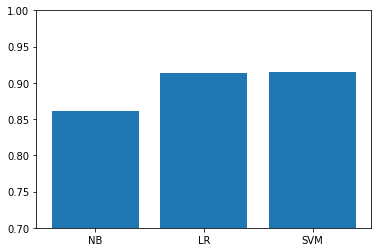

In [139]:
## Test accuracy of each model

def find_accuracy(df):
    total = len(df)
    score = 0 
    for i in range(len(df)):
        if (df['true_labels'][i] == df['predicted_labels'][i]):
            score += 1
    return float(score)/total
            
dfSVM = pd.read_csv("pickleFiles/modelPerformance/resultSVM.csv", encoding='latin1')
dfLR = pd.read_csv("pickleFiles/modelPerformance/resultLR.csv", encoding='latin1')
dfNB = pd.read_csv("pickleFiles/modelPerformance/resultNB.csv", encoding='latin1')

accSVM = find_accuracy(dfSVM)
accLR = find_accuracy(dfLR)
accNB = find_accuracy(dfNB)

models = ['NB', 'LR', 'SVM']
accuracy = [accNB, accLR, accSVM]
plt.ylim(.70, 1.0)
plt.bar(models,accuracy) 
plt.show()

## Step 5: restore final trained model 

In [140]:
## We will use SVM to test since it was the most accurate at 92%
## Load saved SVM model and transform on test samples 

load_modelSVM = pickle.load(open("pickleFiles/trainedModels/modelSVM.pkl","rb"))

In [149]:
## The following lines will be used to test classification in real time
sentiment_labels = ["BAD REVIEW","GOOD REVIEW"]

def test_func(text):
    example_features = tfidf2.transform(text).toarray()
    predict_example = load_modelSVM.predict(example_features)
    return predict_example

def print_pred(pred):
    print (sentiment_labels[int(pred)])

example1 = ["The product was amazing! Came right away and now my phone looks great"]
example2 = ["The product did not work at all. It broke right away!"]
example3 = ["My iphone will not charge no matter how long I wait. I would like a refund"]
example4 = ["The phone case fit perfectly and looked really nice. I received many compliments"]
example5 = ["The charger I bought it great! It chargest my Iphone 8 and is really fast"]
example6 = ["Best headphones for their price point. I really liked them and would 100% recommend to my friends"]

print_pred(test_func(example1))
print_pred(test_func(example2))
print_pred(test_func(example3))
print_pred(test_func(example4))
print_pred(test_func(example5))
print_pred(test_func(example6))

GOOD REVIEW
BAD REVIEW
BAD REVIEW
GOOD REVIEW
GOOD REVIEW
GOOD REVIEW


In [151]:
## Use this cell for live demo

sentiment_labels = ["BAD REVIEW","GOOD REVIEW"]

test = ["The phone case works great. I got lots of compliments!"]

print_pred(test_func(test))

GOOD REVIEW


In [152]:
## Use this cell for live demo

sentiment_labels = ["BAD REVIEW","GOOD REVIEW"]

test = ["This phone case is terrible. Fraud!! I want my money back"]

print_pred(test_func(test))

BAD REVIEW


## The below is for future expansion (Ignore on run)

In [143]:
# ## Commented code for an attempt to optimize SVM parameters. (Future target!)

# control_svm =svm.SVC(random_state=42)
# print(control_svm.get_params())

# # Create C
# C = [.0001, .001, .01]

# # Create gamma
# gamma = [.0001, .001, .01, .1, 1, 10, 100]

# # Create kernel
# kernel = ['linear', 'poly', 'rbf']

# # Create degree
# degree = [1, 2, 3]

# # Create probability
# probability = [True]

# # Create the random grid
# random_grid = {'C': C,
#               'kernel': kernel,
#               'gamma': gamma,
#               'degree': degree,
#               'probability': probability
#              }

# print(random_grid)

In [144]:
# from sklearn.model_selection import RandomizedSearchCV

# # Definition of the random search
# random_search = RandomizedSearchCV(estimator=control_svm,
#                                    param_distributions=random_grid,
#                                    n_iter=15,
#                                    cv=2, 
#                                    verbose=True, 
#                                    random_state=42)

# # Fit the random search model
# random_search.fit(features_train, labels_train)

# print("Ideal hyperparameters:")
# print(random_search.best_params_)
# print("")
# print("Average accuracy:")
# print(random_search.best_score_)